# PhD proposal - Matteo Pompili
$\newcommand{\ket}[1]{|{#1}\rangle} 
\newcommand{\bra}[1]{\langle{#1}|} 
\newcommand{\braket}[1]{\langle{#1}\rangle}$

## Research goal

The goal of my PhD is: **Demonstration of quantum applications on a multi-node network**

## Achieved so far

### Experimentally

So far I built a new setup (LT5) that will act as one of the nodes in three-node experiment.
By the end of November we should be able to generate entanglement between LT5 and LT4. 

### Courses

#### January 2018
+ Collaboration across disciplines (? GSC)

#### October 2018  

+ Conversation skills (2 GSC)

#### November 2018

+ Casimir Course - Programming (5 GSC)
+ <del>The Art of Presenting Science (5 GSC)<del>
+ QuTech Academy - Quantum Communication and Cryptography (5 GSC)

#### December 2018

+ Casimir Course - Electronics for Physicists (5 GSC)

### Supervision

I have been supervising Hans K. C. Beukers, a MSc student, since February. He has been working on improvements that, if successful, will increase the lifetime of our memory qubits.

### Outreach

I carried out two outreach activities within my MSCA network (*Spin-NANO*):

+ January 2018, Sheffield, UK. Introduction to quantum- and nano-technologies to local high-school students.
+ September 2018, Brussels, BE. Two days stand about quantum technologies at the ERN, EU Parlamentarium, mainly to children between 5 and 10.

## Plan

#### 2019

*Demonstrate the generation of a 3-node GHZ state* and use it to test violation of an appropriate inequality.
One of the nodes will use a memory qubit. (First half of 2019)

To be able to carry out complex experiments on a 3+ node network with NV centres we need to overhaul our classical controls. 
In particular, our software infrastructure, although very powerful, has not been updated in years. As a consequence implementing the new experiments would become extremely challenging. 
*I therefore plan to rewrite the needed software in a modern framework.* 
I will use the framework that is being developed for the QINC-demonstrator (qmi) and adapt and update our old code to run on this new platform. (Second half / third quarter of 2019)

#### 2020

*Build 4th node and demonstrate deterministic teleportation of entanglement* as proposed in the QNETWORK proposal. To achieve this we will need memory qubits on at least two nodes.

note: Simon is probably leaving @ 3/4 of this year.

#### 2021

*Client-server secure delegation*, propsed in the QIA proposal. That should run using the whole network stack. We should run a non-stack version of it on our 4 nodes.


*Write thesis*

### Genertion of a 3-node GHZ state

<img src="images/sketch_three_nodes.jpg" width="50%">

Let's try to estimate the fidelity of the expected GHZ state. It is likely that we will run the first and second entanglment with different rates $\alpha$, that is $\alpha_1$ and $\alpha_2$.

The first entangled state, generated between *Alice* and *Charlie*, will run with $\alpha_1$. We will probably prefer to run with a low rate here, to maximize fidelity, such that we can run faster with the second one (and lose less on dechoerence of the first entangled state). Let's say we choose $\alpha_1 = \max_{F_{AC}} \alpha$, where $F_{AC}$ is the maximum fidelity of the entangled state between A and C. Dark counts on the ZPL detectors limit the minimum rate, so there will be an $\alpha_1 > 0$ s.t. fidelity is optimized.

#### Ideal fidelity

If one assumes no dark counts and no other imperfections in the entanglement generation the fidelity of the state goes like $F(\alpha) = (1-\alpha)$

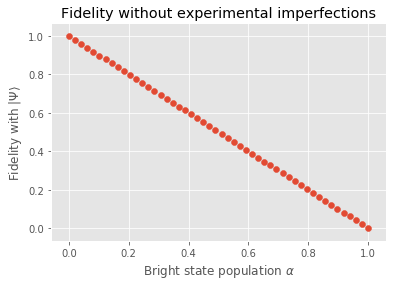

In [2]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def fidelity(*args):
    return qt.fidelity(*args)**2

alphas = np.linspace(0,1)
fids = np.zeros_like(alphas)
for i, x in enumerate(alphas):
    updown = qt.tensor(qt.basis(2,1), qt.basis(2,0))
    downup = qt.tensor(qt.basis(2,0), qt.basis(2,1))
    upup = qt.tensor(qt.basis(2,1), qt.basis(2,1))
    psi_ac = (updown + downup).unit()
    rho_ac = (1-x) * qt.ket2dm(psi_ac) + (x) * qt.ket2dm(upup)
    fids[i] = fidelity(rho_ac, qt.ket2dm(psi_ac))
    
plt.title('Fidelity without experimental imperfections')
plt.xlabel(r'Bright state population $\alpha$')
plt.ylabel(r'Fidelity with $|\Psi\rangle$')
plt.scatter(alphas, fids)
plt.show()

The new entangled state can be generated faster with lower fidelity than the first. Let's try to write down the whole thing.

**Qubit 1 is electron_alice. Qubit 2 is electron_bob. Qubit 3 is carbon_bob. Qubit 4 is electron_charlie.**

We assume the fidelity-rate curves of deterministic entanglement (altought we could be able to do better, by getting rid of excitation light in the ZPL).
MBy matching it with the experimental data it looks like the following function might do.

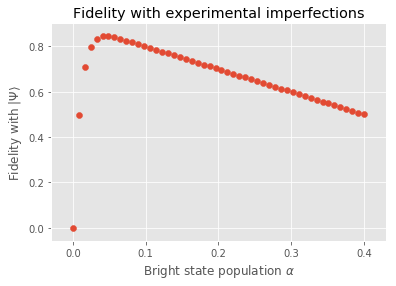

Max fidelity achievable with old parameters is 0.846, 
at alpha = 0.045, 
which corresponds to a rate = 5.6 Hz


In [3]:
def alpha_to_fidelity(alpha, dc = 0.01, top_fid = 0.9):
    return (1 - np.exp(-alpha/dc)) * (top_fid - alpha)

def alpha_to_rate(alpha, speed = 125):
    return alpha * speed

def decohere(m, t, t0):
    if isinstance(t, int):
        data = m.full()
        diag_m = np.diagflat(m.diag())
        data = diag_m + (data - diag_m) * np.exp(-t/t0)
        return qt.Qobj(data, dims=m.dims)
    else:
        result = np.zeros_like(t, dtype=type(m))
        for i, time in enumerate(t):
            data = m.full()
            diag_m = np.diagflat(m.diag())
            data = diag_m + (data - diag_m) * np.exp(-time/t0)
            result[i] = qt.Qobj(data, dims=m.dims)
        return result

import scipy as sp
from scipy import optimize

# Plot fidelity vs alpha curve
alphas = np.linspace(0,0.4)
fids = np.zeros_like(alphas)
plt.title('Fidelity with experimental imperfections')
plt.xlabel(r'Bright state population $\alpha$')
plt.ylabel(r'Fidelity with $|\Psi\rangle$')
plt.scatter(alphas, alpha_to_fidelity(alphas))
plt.show()

opt_res = sp.optimize.minimize_scalar(lambda x: - alpha_to_fidelity(x), bounds=(0,1))
slow_alpha = opt_res.x
print ('Max fidelity achievable with old parameters is {:.3f}, \nat alpha = {:.3f}, \nwhich corresponds to a rate = {:.1f} Hz'\
       .format(alpha_to_fidelity(slow_alpha),
               slow_alpha, 
               alpha_to_rate(slow_alpha)))

#### Make first entanglement and swap to carbon

In [4]:
# Generate entangled state with max fidelity
q1q4_ent_state = alpha_to_fidelity(slow_alpha) * qt.ket2dm(psi_ac) + (1- alpha_to_fidelity(slow_alpha)) * qt.ket2dm(upup)

# Apply swap gate or project in mixed state
p_swap = 0.95
mixed_state = qt.tensor(qt.maximally_mixed_dm(2), qt.maximally_mixed_dm(2))
q1q3_ent_state = p_swap * q1q4_ent_state + (1 - p_swap) * mixed_state

print('Now fidelity with Bell state is {}'.format(fidelity(q1q3_ent_state, qt.ket2dm(psi_ac))))

Now fidelity with Bell state is 0.81573408796723


#### Second entangled state

In [5]:
# Now we generate entangled state again with lower alpha and we dechoere the first one according to rate

fast_alpha = 0.1
fast_rate = alpha_to_rate(fast_alpha)
slow_rate = alpha_to_rate(slow_alpha)
fast_cycles = 20# 1. / fast_rate / 5.5E-6
prob_generation_before_timeout = 1 - np.exp(- fast_rate * 5.5E-6 * fast_cycles) 

cycles_of_coherence = 1000
decohered_q1q3_ent_state = decohere(q1q3_ent_state, t=fast_cycles, t0=cycles_of_coherence)

q2q4_ent_state = alpha_to_fidelity(fast_alpha) * qt.ket2dm(psi_ac) + (1- alpha_to_fidelity(fast_alpha)) * qt.ket2dm(upup)

joint_state = qt.tensor(decohered_q1q3_ent_state, q2q4_ent_state)

# And let's reorder the tensor such that we much the previous defintion of qubits.
joint_state = joint_state.permute([0,2,1,3])
print('Fidelity of q1-q3 to bell state: {:.2f}'.format(fidelity(joint_state.ptrace([0,2]), qt.ket2dm(psi_ac))))
print('Fidelity of q2-q4 to bell state: {:.2f}'.format(fidelity(joint_state.ptrace([1,3]), qt.ket2dm(psi_ac))))
print('Probability of getting the state before timeout: {:.2f}%'.format(prob_generation_before_timeout * 100))
print('Overall generation rate: {:1f} Hz'.format((1/fast_rate + 1/slow_rate) * (prob_generation_before_timeout)))
print('Overall generation time: {:1f} s'.format(1/((1/fast_rate + 1/slow_rate) * (prob_generation_before_timeout))))

Fidelity of q1-q3 to bell state: 0.81
Fidelity of q2-q4 to bell state: 0.80
Probability of getting the state before timeout: 0.14%
Overall generation rate: 0.000356 Hz
Overall generation time: 2806.162495 s


#### Conditional gate

Now we want to apply our conditional rotations to entangle q3 with q4 (carbon and electron of Charlie) and then disentangle q4 by measurement and feedback.

<img src="images/cond_gate_el_ca.png" width="20%">

In [6]:
q4_xmpi2 = qt.rotation(qt.sigmax(), -np.pi/2, 4, 3)
q4_xppi2 = qt.rotation(qt.sigmax(), +np.pi/2, 4, 3)
controlled_rot1 = qt.controlled_gate(qt.rotation(qt.sigmax(), np.pi/2), N=4, control=3, target=2, control_value=0)
controlled_rot2 = qt.controlled_gate(qt.rotation(qt.sigmax(), -np.pi/2), N=4, control=3, target=2, control_value=1)
elec_carb_gate = q4_xppi2 * controlled_rot2 * controlled_rot1 * q4_xmpi2

joint_state = elec_carb_gate * joint_state * elec_carb_gate.dag()

Now we can apply our classical feedback after measuring q4. If it is in zero we don't do anything.

In [7]:
q4_zero_proj = qt.tensor(qt.identity(2), qt.identity(2), qt.identity(2), qt.basis(2, 0).proj())
q4_one_proj = qt.tensor(qt.identity(2), qt.identity(2), qt.identity(2), qt.basis(2, 1).proj())

classical_feedback = q4_zero_proj + q4_one_proj*qt.rotation(qt.sigmax(), np.pi, 4, 0)*qt.rotation(qt.sigmaz(), np.pi, 4, 1)
final_state = (classical_feedback * joint_state * classical_feedback.dag()).ptrace([0,1,2])

In [8]:
zero = qt.basis(2, 0)
one  = qt.basis(2, 1)
s000 = qt.tensor(zero, zero, zero)
s110 = qt.tensor(one, one, zero)
s101 = qt.tensor(one, zero, one)
s011 = qt.tensor(zero, one, one)
target_state = (s000 + s110 + s101 + s011).unit()

print('Fidelity of GHZ-like final state with target state: {:0.3f}'.format(fidelity(final_state, target_state)))

Fidelity of GHZ-like final state with target state: 0.655


#### Sweep of $\alpha$ and generation timout of the second state

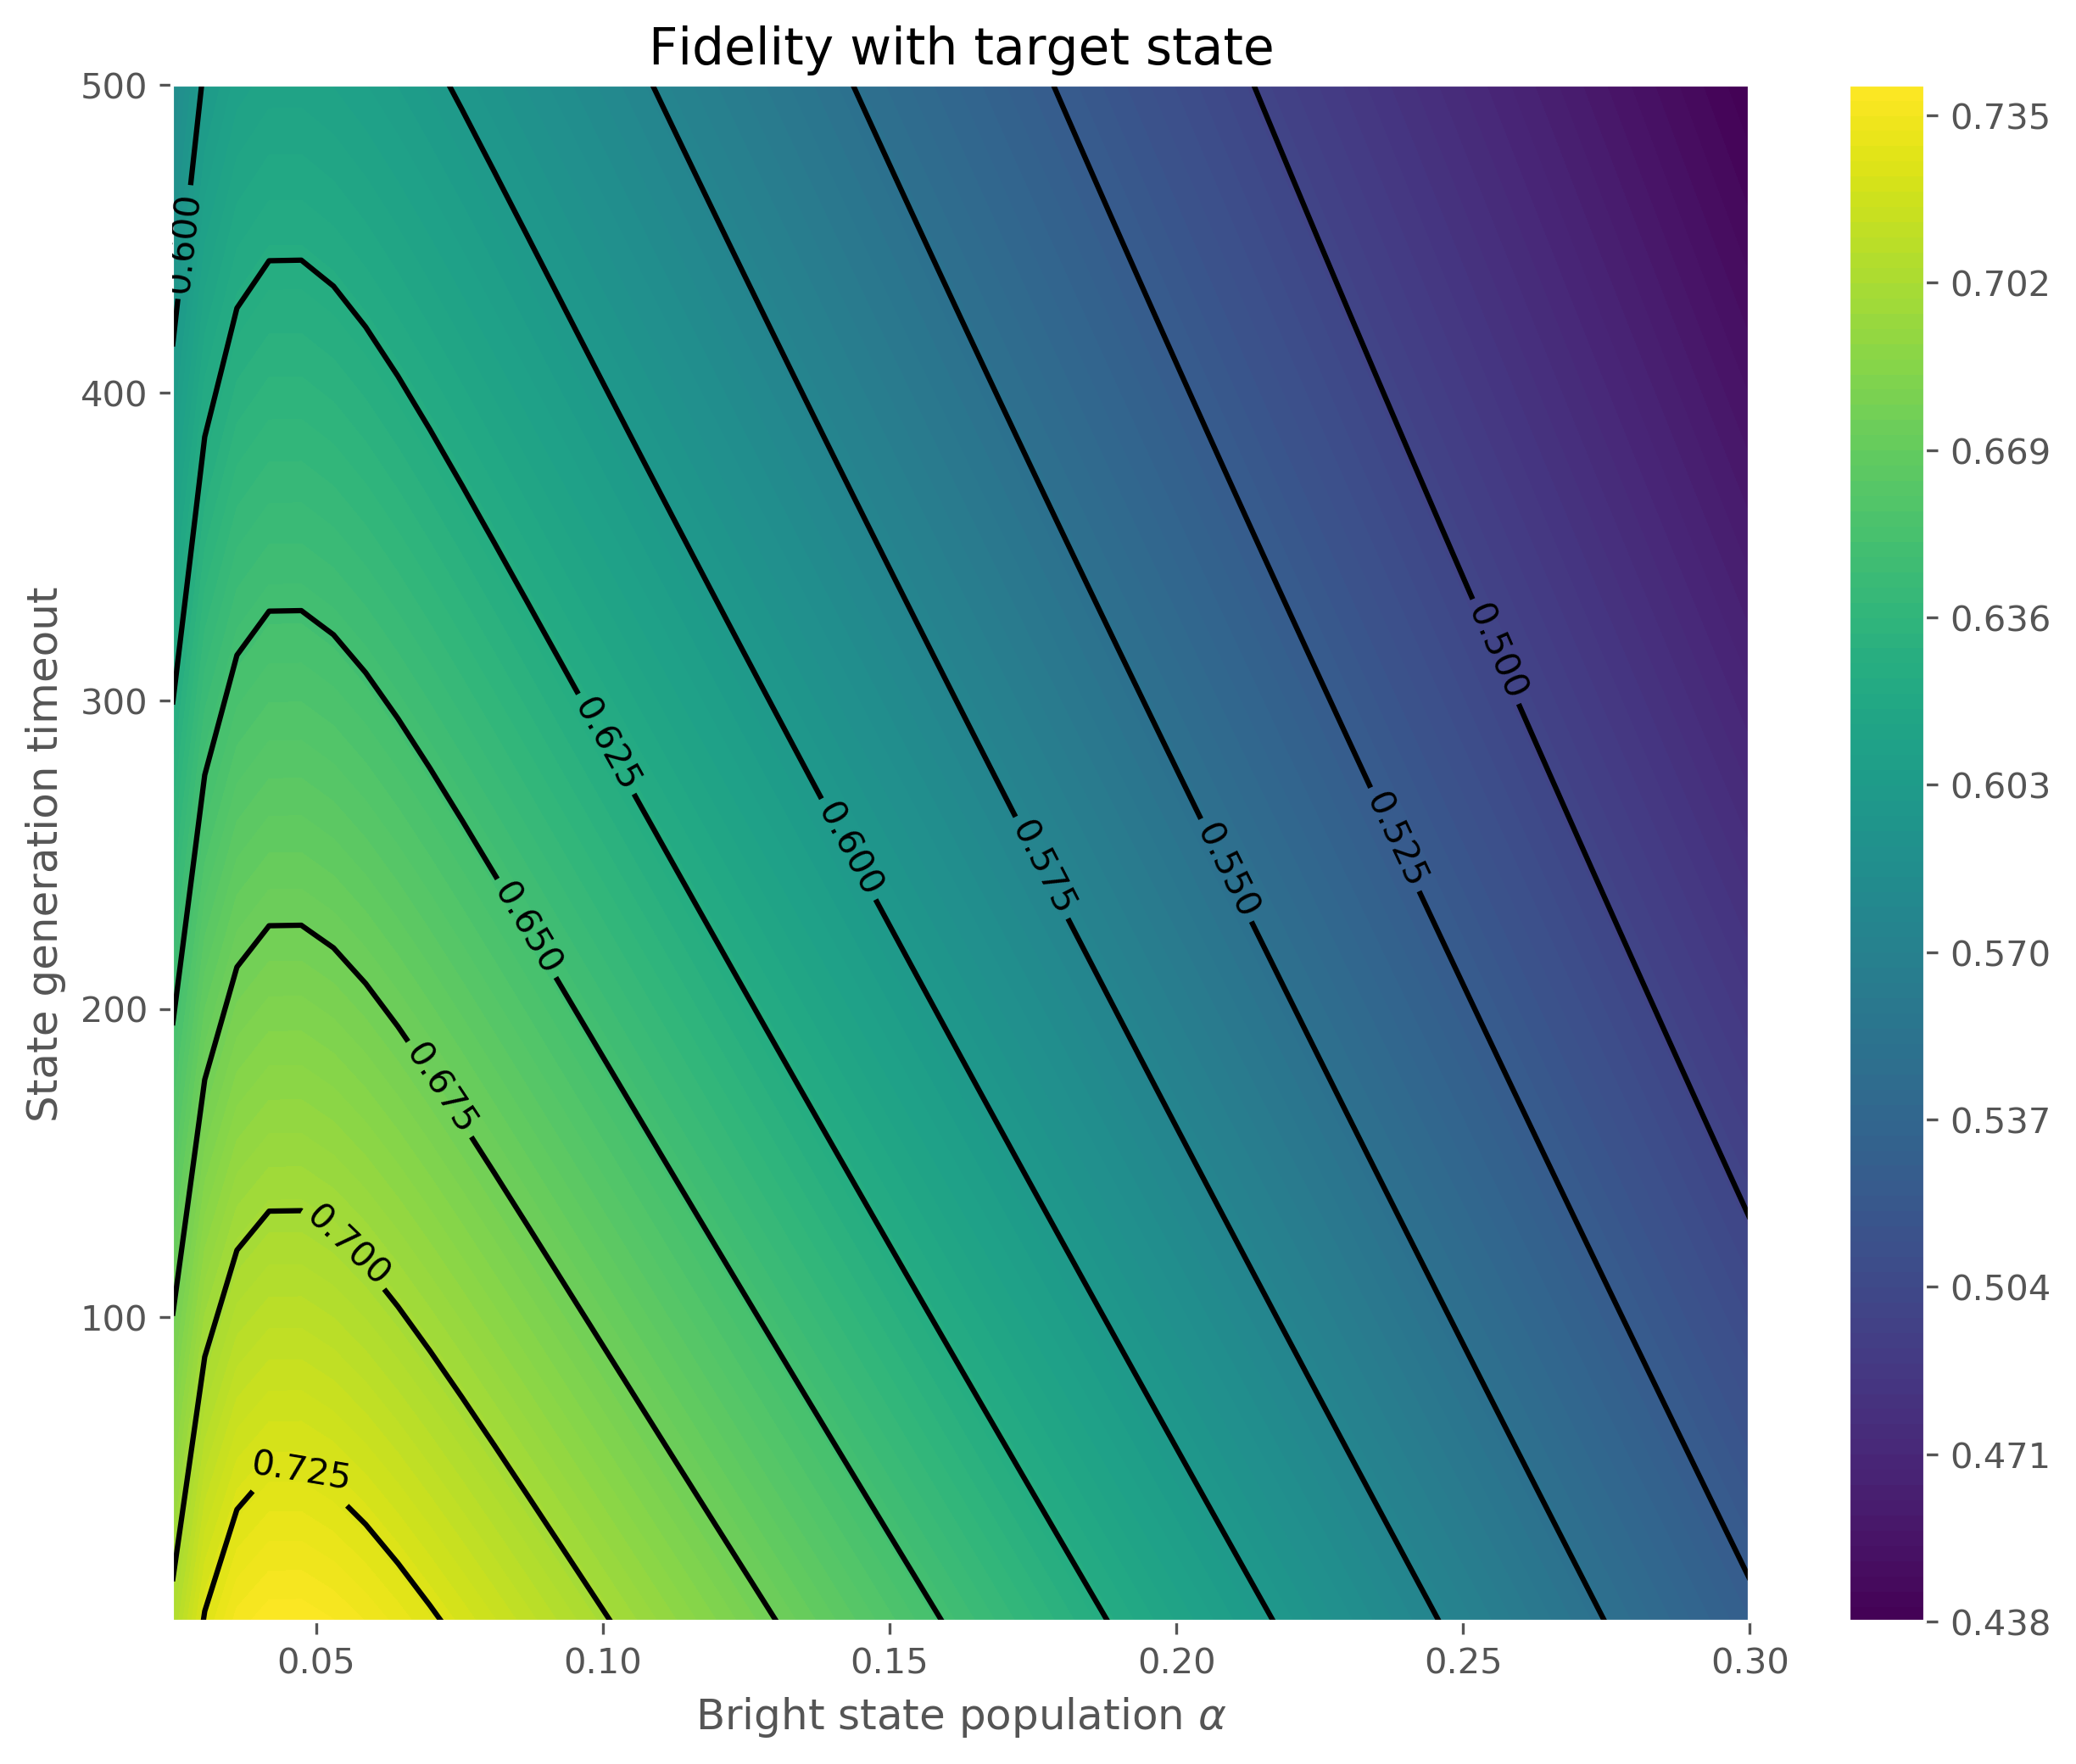

In [309]:
size = 50
fast_alpha = np.linspace(0.025, 0.3, num=size)
fast_rate = alpha_to_rate(fast_alpha)
slow_rate = alpha_to_rate(slow_alpha)
fast_cycles = np.linspace(1, 500, num=size, dtype=int)# 1. / fast_rate / 5.5E-6
# first index is alpha, second is cycles
prob_generation_before_timeout = 1 - np.exp(- fast_rate[:, np.newaxis] * 5.5E-6 * fast_cycles) 

cycles_of_coherence = 1000
decohered_q1q3_ent_state = decohere(q1q3_ent_state, t=fast_cycles, t0=cycles_of_coherence)

q2q4_ent_state = list(alpha_to_fidelity(fast_alpha)) * qt.ket2dm(psi_ac) + list((1- alpha_to_fidelity(fast_alpha))) * qt.ket2dm(upup)

from itertools import product

joint_state = np.zeros_like(prob_generation_before_timeout, dtype=type(q2q4_ent_state))
for i,j in product(range(size), range(size)):
    joint_state[i,j] = qt.tensor(decohered_q1q3_ent_state[j], q2q4_ent_state[i]).permute([0,2,1,3])
    joint_state[i,j] = elec_carb_gate * joint_state[i,j] * elec_carb_gate.dag()

final_state = np.zeros_like(prob_generation_before_timeout, dtype=type(q2q4_ent_state))
for i,j in product(range(size), range(size)):
    final_state[i,j] = (classical_feedback * joint_state[i,j] * classical_feedback.dag()).ptrace([0,1,2])

fids =  np.zeros_like(prob_generation_before_timeout)
for i,j in product(range(size), range(size)):
    fids[i,j] = fidelity(final_state[i,j], target_state)

plt.figure(figsize=(10,8), dpi=300)
plt.title('Fidelity with target state')
plt.contourf(fast_alpha, fast_cycles, fids.transpose(), levels=100)
plt.colorbar()
cont = plt.contour(fast_alpha, fast_cycles, fids.transpose(), colors='k', levels=np.arange(0.5, 0.8, 0.025))
plt.clabel(cont, inline=1, fontsize=10)
plt.xlabel(r'Bright state population $\alpha$')
plt.ylabel(r'State generation timeout')
plt.show()

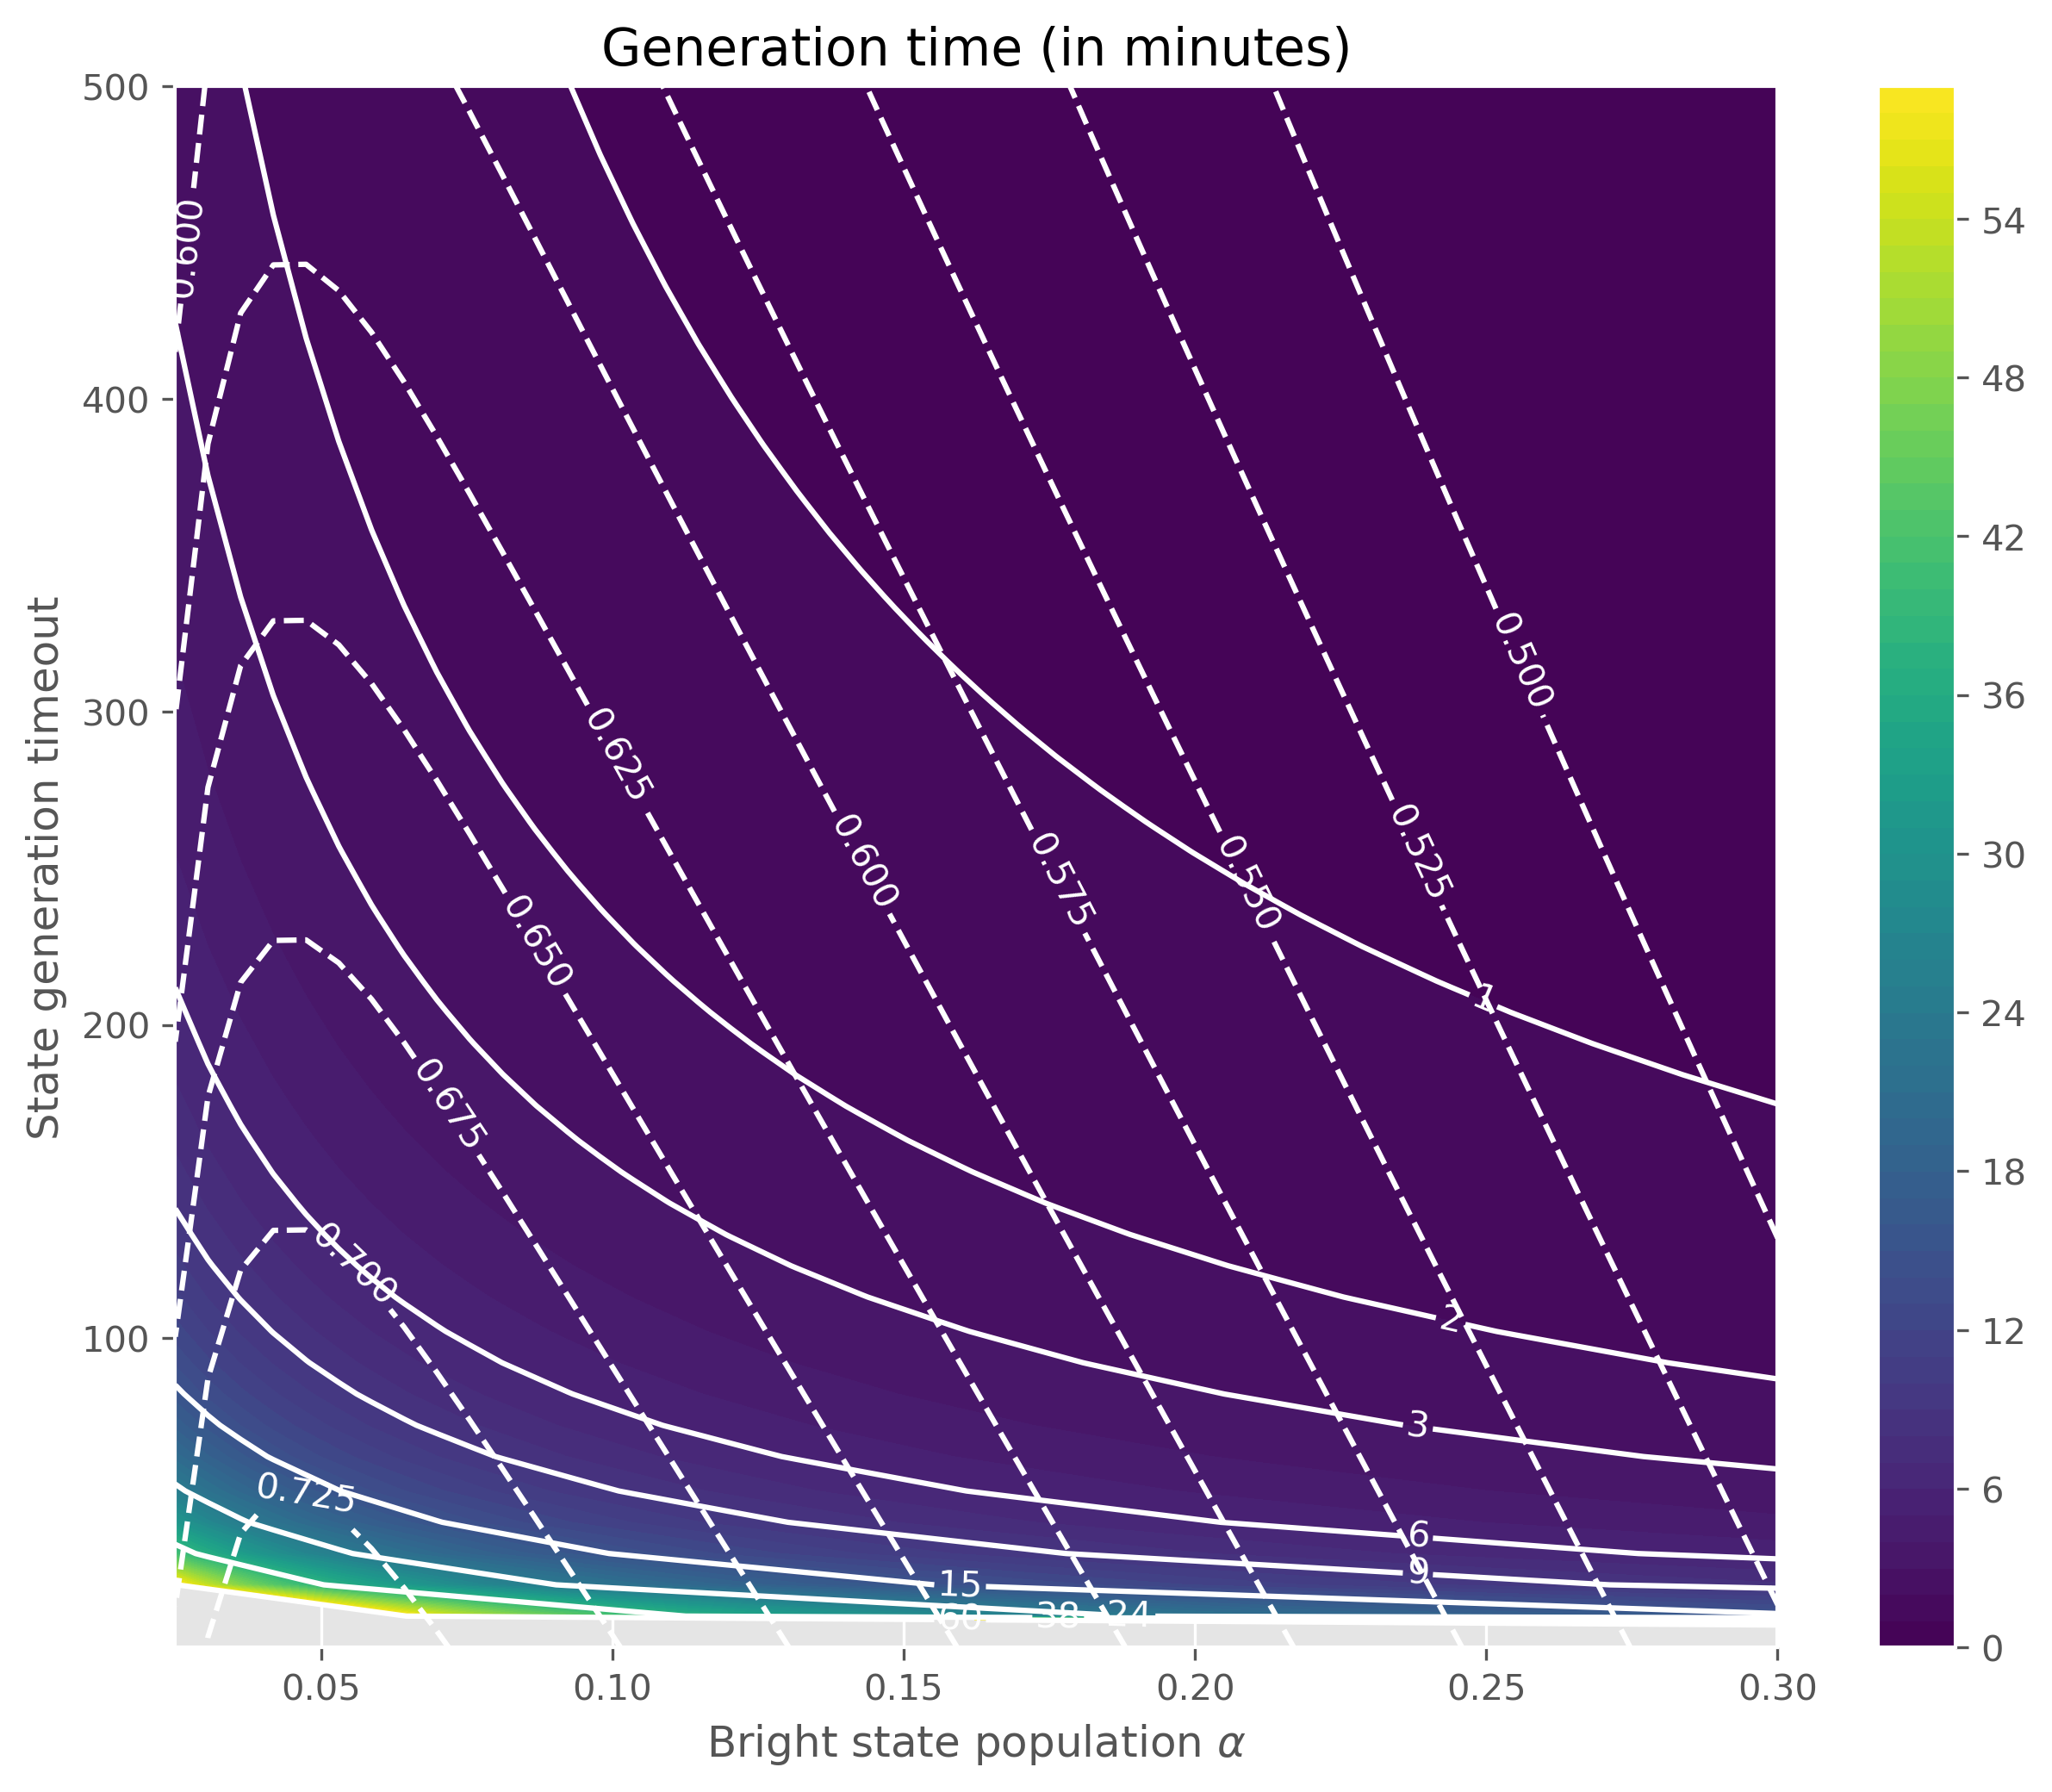

In [313]:
gen_time = 1/((1/fast_rate[:, np.newaxis] + 1/slow_rate) * (prob_generation_before_timeout))

from matplotlib.colors import LogNorm

plt.figure(figsize=(10,8), dpi=300)
plt.title('Generation time (in minutes)')
plt.contourf(fast_alpha, fast_cycles, gen_time.transpose() / 60, levels = np.arange(0, 60, 1))
plt.colorbar()
plt.xlabel(r'Bright state population $\alpha$')
plt.ylabel(r'State generation timeout')

cont = plt.contour(fast_alpha, fast_cycles, fids.transpose(), colors='w', levels=np.arange(0.5, 0.8, 0.025), linestyles='dashed')
plt.clabel(cont, inline=1, fontsize=10)

cont_time = plt.contour(fast_alpha, fast_cycles, gen_time.transpose() / 60, colors='w', levels = np.unique(np.geomspace(1,60,10, dtype=int)))
plt.clabel(cont_time, inline=1, fontsize=10, fmt="%d")

plt.show()

#### Possible near-future experimental values

In [297]:
# Simulate entangled state

def sim_rho_from_alpha(alpha, print_fids = False, return_fid = True, 
                      det_w = 25e-9, PdetA = 2.8e-4, PdetB = 4.2e-4, 
                      vis = 0.8, P2e = 0.04, phase_unc = 15):

#     det_w = 25e-9 # from 25. We should have less excitation light in the ZPL/
    
#     PdetA = 2e-4 # from 2e-4
#     PdetB = 4e-4 # from 4e-4
#     vis = 0.8
    
#     P2e = 0.04 #from 0.04
    
#     phase_unc = 15 
    
    Pdc = 10 * det_w
    Puu = alpha**2 * ((1-Pdc)**2 * (PdetA*(1-PdetB) + PdetB*(1-PdetA)) + 2*(1-Pdc)*Pdc*(1-PdetA)*(1-PdetB))
    Pud = alpha*(1-alpha)*((1-Pdc)**2 * PdetA + 2*Pdc*(1-Pdc)*(1-PdetA))
    Pdu = alpha*(1-alpha)*((1-Pdc)**2 * PdetB + 2*Pdc*(1-Pdc)*(1-PdetB))
    Pdd = 2*(1-alpha)**2 * Pdc*(1-Pdc)

    rho = np.array([
        [Pdd, 0, 0, 0],
        [0, Pud, np.sqrt(vis * Pud * Pdu), 0],
        [0, np.sqrt(vis * Pud * Pdu), Pdu, 0],
        [0, 0, 0, Puu]])

    rho = rho/rho.trace()
    rho = qt.Qobj(rho, dims=[[2, 2], [2, 2]])
    if print_fids : print('Fidelity after SCE: {:.3f}'.format(fidelity(rho, qt.ket2dm(qt.bell_state('10')))))

    # Simulate double excitation

    z_i = qt.tensor(qt.sigmaz(), qt.identity(2))
    i_z = qt.tensor(qt.identity(2), qt.sigmaz())
    z_z = qt.tensor(qt.sigmaz(), qt.sigmaz())
    rho = (1 - P2e/2)**2 * rho \
        + (1 - P2e/2) * (p2e/2) * z_i * rho * z_i.dag() \
        + (1 - P2e/2) * (p2e/2) * i_z * rho * i_z.dag() \
        + (P2e/2)**2 * z_z * rho * z_z.dag()
    if print_fids : print('Fidelity after double excitation: {:.3f}'.format(fidelity(rho, qt.ket2dm(qt.bell_state('10')))))

    # Simulate phase uncertainty
    
    phase_unc = phase_unc / 180 * np.pi
    Pe = 0.5 * (1 - np.exp(-0.5 * phase_unc**2))
    rho = (1 - Pe) * rho \
        + Pe * i_z * rho * i_z.dag()
    if print_fids : print('Fidelity after phase uncertainty: {:.3f}'.format(fidelity(rho, qt.ket2dm(qt.bell_state('10')))))
    
    if return_fid :
        return rho, fidelity(rho, qt.ket2dm(qt.bell_state('10')))
    else:
        return rho

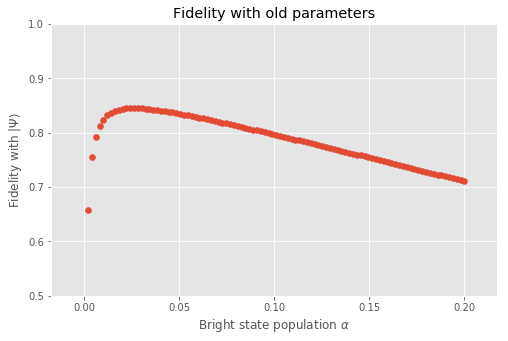

Max fidelity is 0.845 at alpha 0.026

Fidelity after SCE: 0.891
Fidelity after double excitation: 0.858
Fidelity after phase uncertainty: 0.845


In [298]:
alphas = np.linspace(0, 0.2, 100)
fids = np.zeros_like(alphas)
for i, alpha in enumerate(alphas):
    _, fids[i] = sim_rho_from_alpha(alpha)

plt.figure(figsize=(8,5))    
plt.title('Fidelity with old parameters')
plt.xlabel(r'Bright state population $\alpha$')
plt.ylabel(r'Fidelity with $|\Psi\rangle$')
plt.ylim((0.5,1))
plt.scatter(alphas, fids)
plt.show()

print('Max fidelity is {:.3f} at alpha {:.3f}\n'.format(np.max(fids), alphas[np.argmax(fids)]))
sim_rho_from_alpha(alphas[np.argmax(fids)], print_fids=True, return_fid=False);

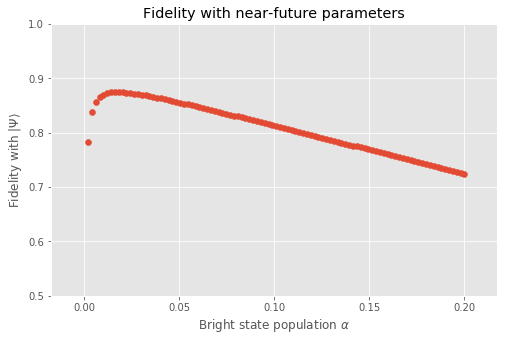

Max fidelity is 0.875 at alpha 0.018

Fidelity after SCE: 0.915
Fidelity after double excitation: 0.899
Fidelity after phase uncertainty: 0.875


In [301]:
alphas = np.linspace(0, 0.2, 100)
fids = np.zeros_like(alphas)

near_future_params = {'det_w': 25e-9, 'PdetA': 8e-4, 'PdetB': 8e-4, 
                      'vis': 0.8, 'P2e': 0.02, 'phase_unc': 20}
for i, alpha in enumerate(alphas):
    _, fids[i] = sim_rho_from_alpha(alpha, **near_future_params)

plt.figure(figsize=(8,5))    
plt.title('Fidelity with near-future parameters')
plt.xlabel(r'Bright state population $\alpha$')
plt.ylabel(r'Fidelity with $|\Psi\rangle$')
plt.ylim((0.5,1))
plt.scatter(alphas, fids)
plt.show()

print('Max fidelity is {:.3f} at alpha {:.3f}\n'.format(np.max(fids), alphas[np.argmax(fids)]))
sim_rho_from_alpha(alphas[np.argmax(fids)], print_fids=True, return_fid=False, **near_future_params);

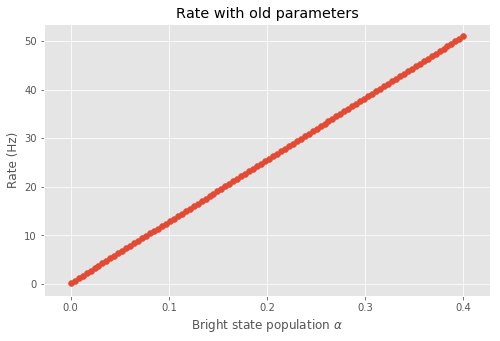

In [296]:
def sim_rate_from_alpha(alpha, det_w = 25e-9, PdetA = 2.8e-4, PdetB = 4.2e-4, 
                      vis = 0.8, P2e = 0.04, phase_unc = 15, ent_duration = 5.5e-6):
    
    Pdc = 10 * det_w
    Puu = alpha**2 * ((1-Pdc)**2 * (PdetA*(1-PdetB) + PdetB*(1-PdetA)) + 2*(1-Pdc)*Pdc*(1-PdetA)*(1-PdetB))
    Pud = alpha*(1-alpha)*((1-Pdc)**2 * PdetA + 2*Pdc*(1-Pdc)*(1-PdetA))
    Pdu = alpha*(1-alpha)*((1-Pdc)**2 * PdetB + 2*Pdc*(1-Pdc)*(1-PdetB))
    Pdd = 2*(1-alpha)**2 * Pdc*(1-Pdc)
    
    return 1/ent_duration * (Puu + Pud + Pdu + Pdd)

alphas = np.linspace(0, 0.4, 100)
rates = np.zeros_like(alphas)

for i, alpha in enumerate(alphas):
    rates[i] = sim_rate_from_alpha(alpha)

plt.figure(figsize=(8,5))    
plt.title('Rate with old parameters')
plt.xlabel(r'Bright state population $\alpha$')
plt.ylabel(r'Rate (Hz)')
plt.scatter(alphas, rates)
plt.show()

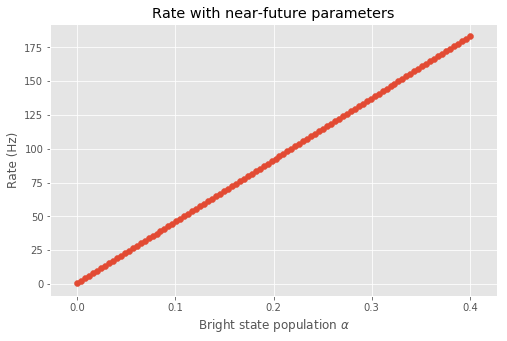

In [253]:
alphas = np.linspace(0, 0.4, 100)
rates = np.zeros_like(alphas)

for i, alpha in enumerate(alphas):
    rates[i] = sim_rate_from_alpha(alpha, ent_duration=3.5e-6, **near_future_params)

plt.figure(figsize=(8,5))    
plt.title('Rate with near-future parameters')
plt.xlabel(r'Bright state population $\alpha$')
plt.ylabel(r'Rate (Hz)')
plt.scatter(alphas, rates)
plt.show()

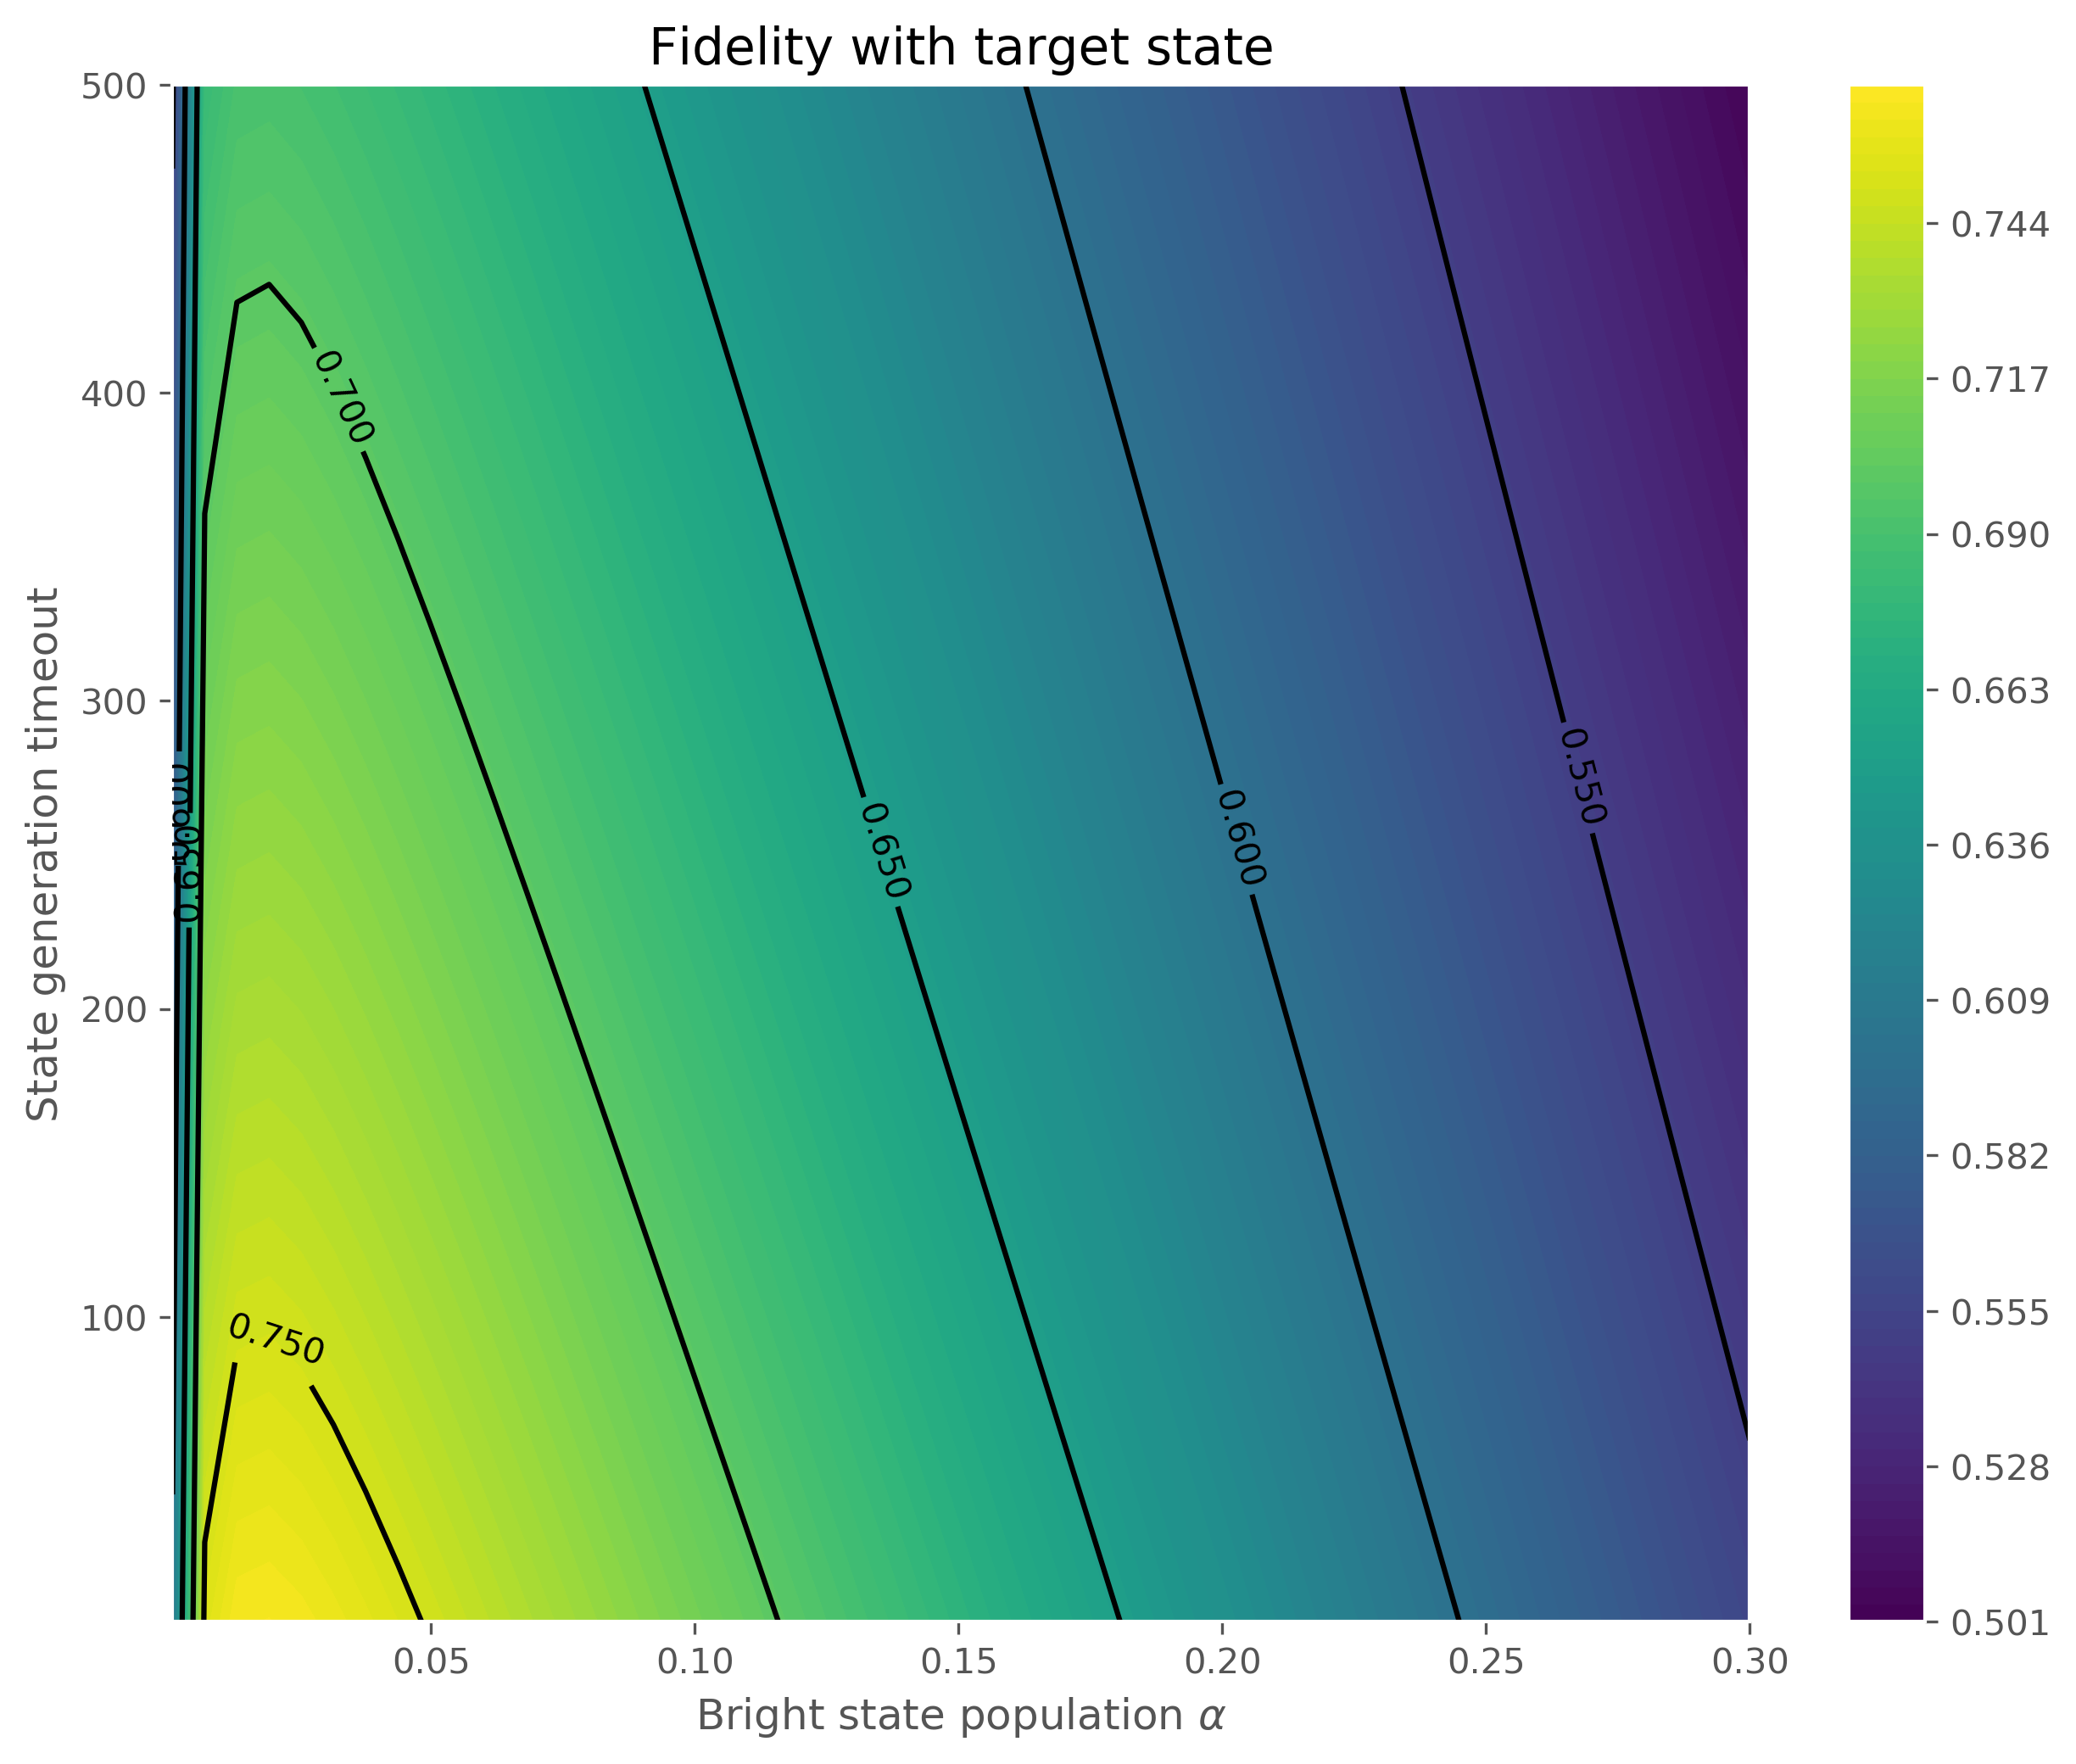

In [314]:
size = 50

slow_alpha = 0.018
q1q3_ent_state, _ = sim_rho_from_alpha(slow_alpha, **near_future_params)

fast_alpha = np.linspace(0.001, 0.3, num=size)
fast_rate = sim_rate_from_alpha(fast_alpha, ent_duration=3.5e-6, **near_future_params)
slow_rate = sim_rate_from_alpha(slow_alpha, ent_duration=3.5e-6, **near_future_params)
fast_cycles = np.linspace(1, 500, num=size, dtype=int)# 1. / fast_rate / 5.5E-6
# first index is alpha, second is cycles
prob_generation_before_timeout = 1 - np.exp(- fast_rate[:, np.newaxis] * 3.5e-6 * fast_cycles) 

cycles_of_coherence = 2000
decohered_q1q3_ent_state = decohere(q1q3_ent_state, t=fast_cycles, t0=cycles_of_coherence)

q2q4_ent_state = []

for alpha in fast_alpha:
    q2q4_ent_state += [sim_rho_from_alpha(alpha, return_fid=False, **near_future_params)]

from itertools import product

joint_state = np.zeros_like(prob_generation_before_timeout, dtype=type(q2q4_ent_state))
for i,j in product(range(size), range(size)):
    joint_state[i,j] = qt.tensor(decohered_q1q3_ent_state[j], q2q4_ent_state[i]).permute([0,2,1,3])
    joint_state[i,j] = elec_carb_gate * joint_state[i,j] * elec_carb_gate.dag()

final_state = np.zeros_like(prob_generation_before_timeout, dtype=type(q2q4_ent_state))
for i,j in product(range(size), range(size)):
    final_state[i,j] = (classical_feedback * joint_state[i,j] * classical_feedback.dag()).ptrace([0,1,2])

fids =  np.zeros_like(prob_generation_before_timeout)
for i,j in product(range(size), range(size)):
    fids[i,j] = fidelity(final_state[i,j], target_state)

plt.figure(figsize=(10,8), dpi=300)
plt.title('Fidelity with target state')
plt.contourf(fast_alpha, fast_cycles, fids.transpose(), levels=100)
plt.colorbar()
cont = plt.contour(fast_alpha, fast_cycles, fids.transpose(), colors='k', levels=np.arange(0.5, 0.8, 0.05))
plt.clabel(cont, inline=1, fontsize=10)
plt.xlabel(r'Bright state population $\alpha$')
plt.ylabel(r'State generation timeout')
plt.show()

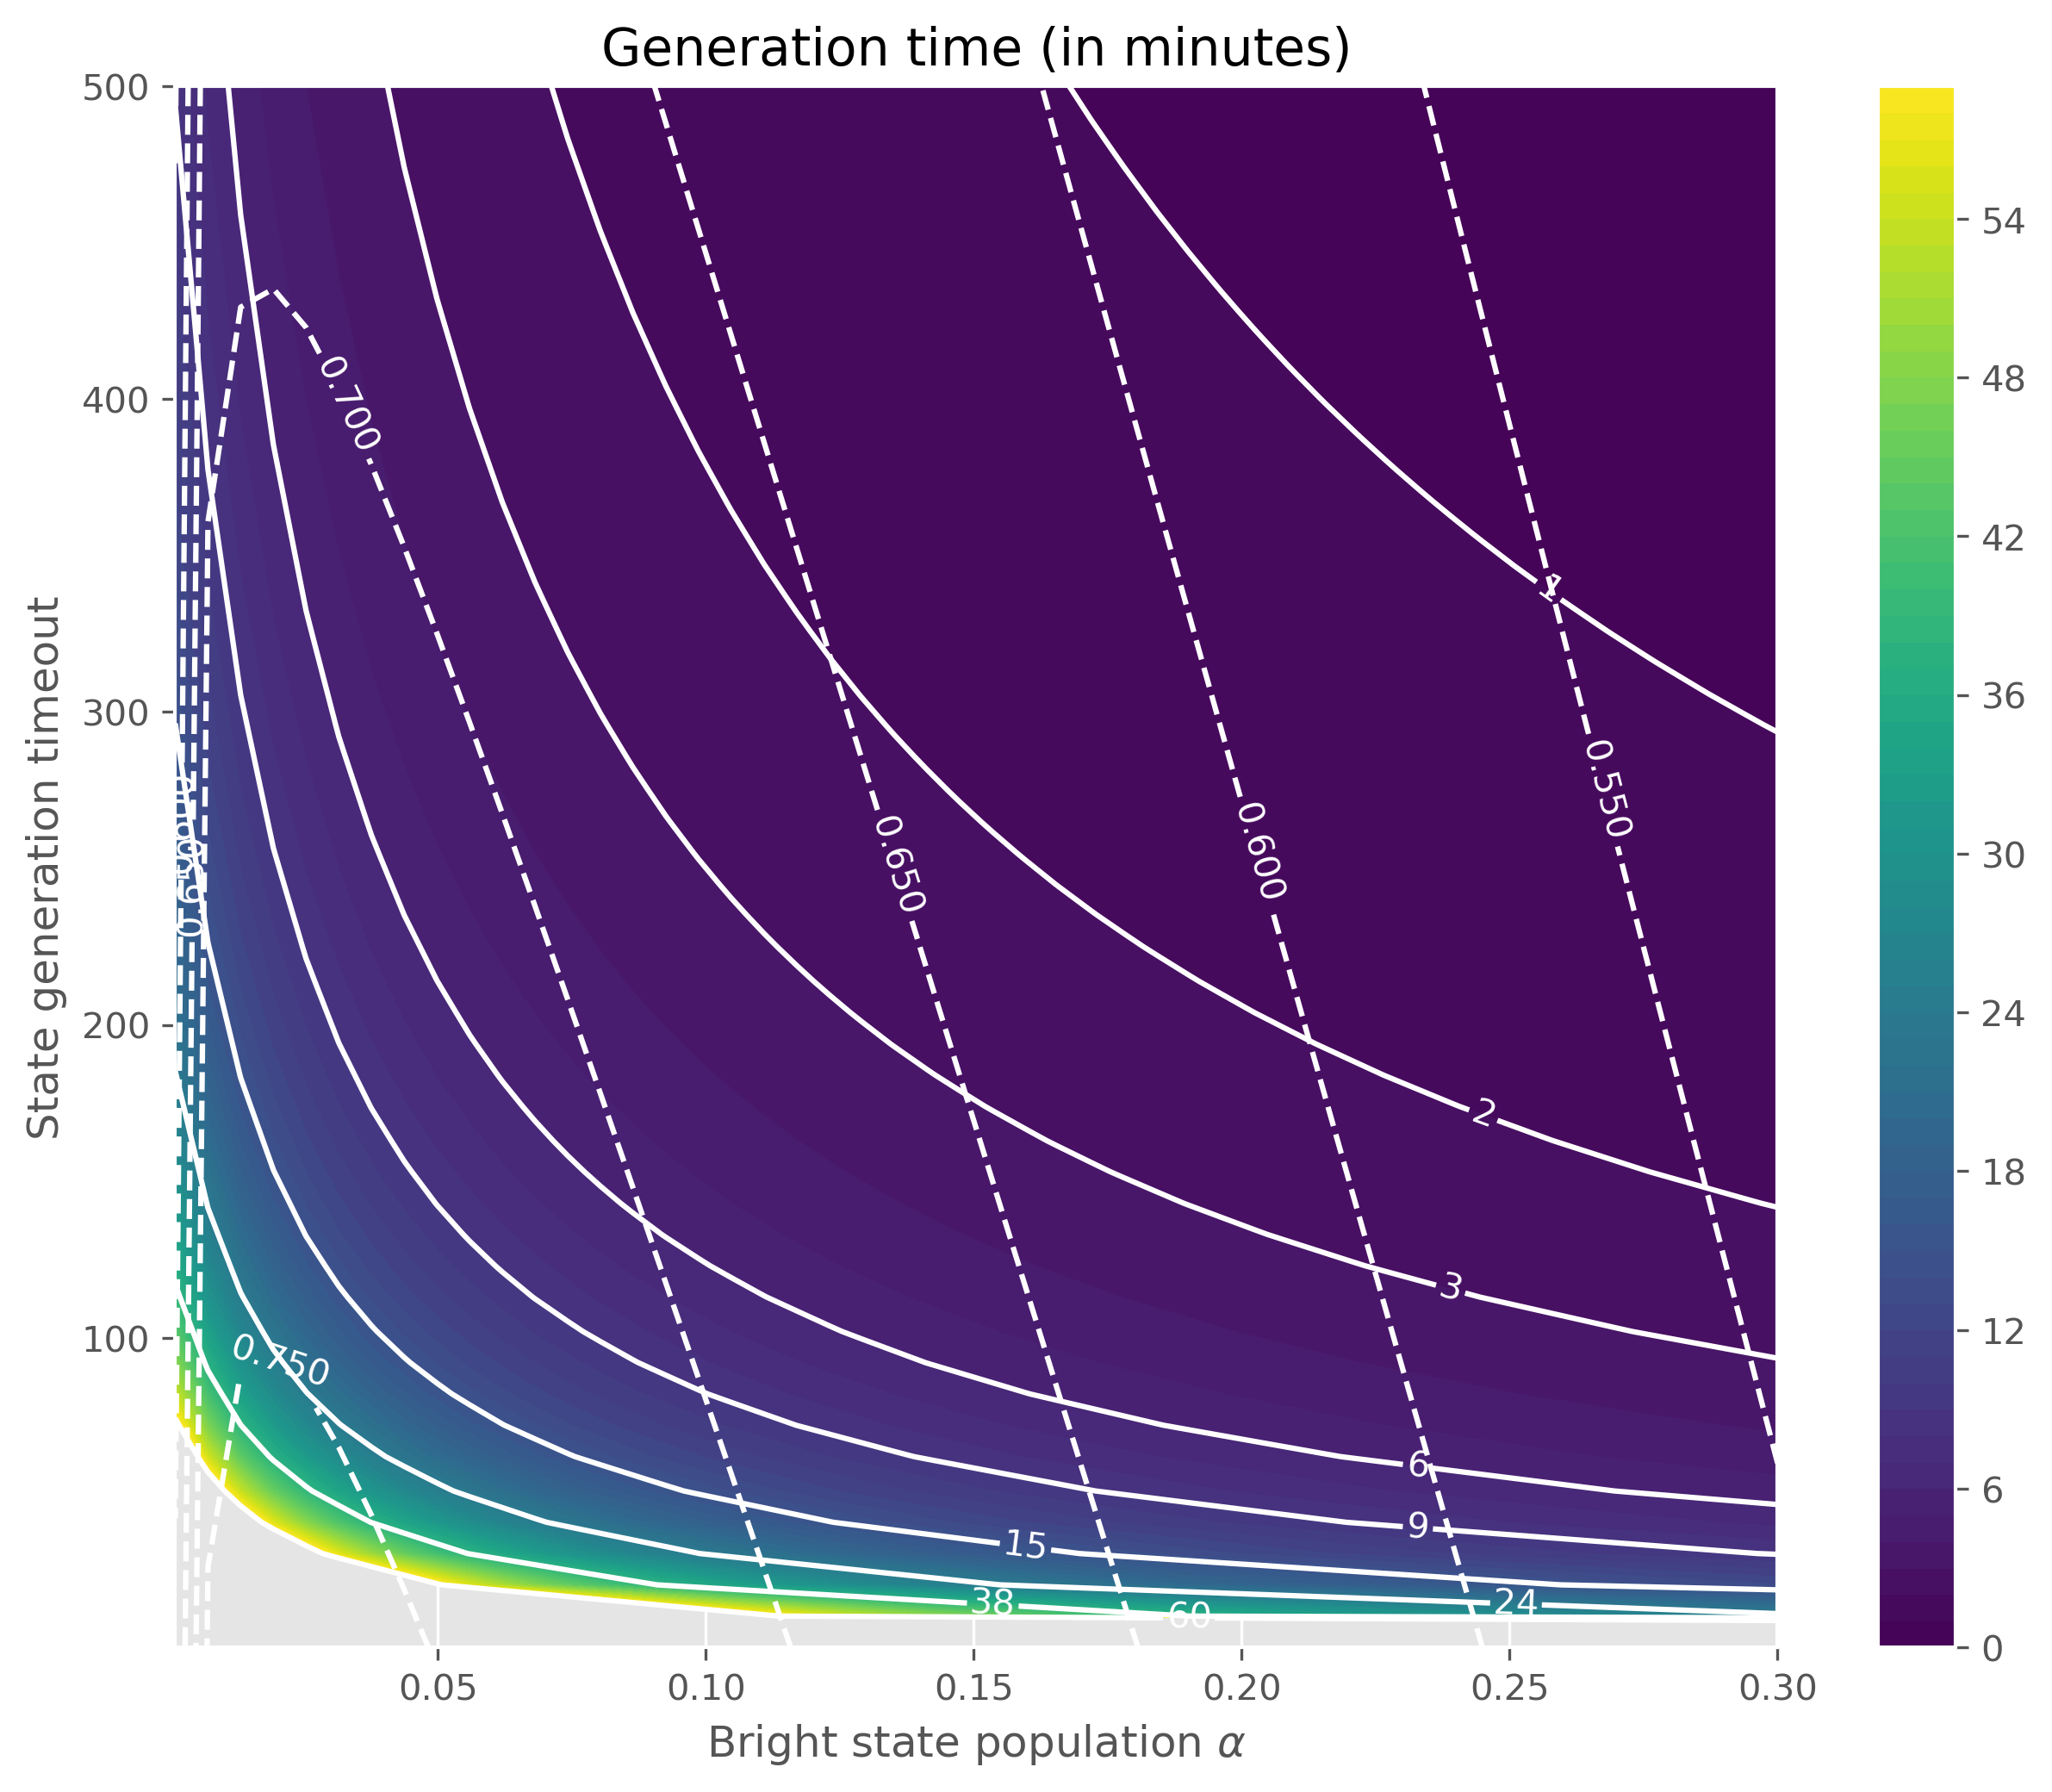

In [315]:
gen_time = 1/((1/fast_rate[:, np.newaxis] + 1/slow_rate) * (prob_generation_before_timeout))

from matplotlib.colors import LogNorm

plt.figure(figsize=(10,8), dpi=300)
plt.title('Generation time (in minutes)')
plt.contourf(fast_alpha, fast_cycles, gen_time.transpose() / 60, levels = np.arange(0, 60, 1))
plt.colorbar()
plt.xlabel(r'Bright state population $\alpha$')
plt.ylabel(r'State generation timeout')

cont = plt.contour(fast_alpha, fast_cycles, fids.transpose(), colors='w', levels=np.arange(0.5, 0.8, 0.05), linestyles='dashed')
plt.clabel(cont, inline=1, fontsize=10)

cont_time = plt.contour(fast_alpha, fast_cycles, gen_time.transpose() / 60, colors='w', levels = np.unique(np.geomspace(1,60,10, dtype=int)))
plt.clabel(cont_time, inline=1, fontsize=10, fmt="%d")

plt.show()